In [1]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

class VisionTransformerPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the default ImageNet pretrained ViT_B_16 weights
        weights = ViT_B_16_Weights.DEFAULT
        self.vit_b_16 = vit_b_16(weights=weights, progress=False).eval()
        self.transforms = weights.transforms(antialias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.vit_b_16(x)
            return y_pred.argmax(dim=1)
        
vit = VisionTransformerPredictor()

In [2]:
vit.vit_b_16.encoder.layers.encoder_layer_0.mlp[0].weight

Parameter containing:
tensor([[ 0.0376,  0.0019,  0.0194,  ...,  0.0079,  0.0176,  0.0022],
        [-0.0324,  0.0013, -0.0095,  ...,  0.0007,  0.0062, -0.0017],
        [-0.0068, -0.0030, -0.0285,  ...,  0.0061, -0.0069,  0.0228],
        ...,
        [-0.0548, -0.0033,  0.0250,  ...,  0.0057, -0.0089, -0.0013],
        [ 0.0046, -0.0130,  0.0104,  ...,  0.0616,  0.0906, -0.0831],
        [-0.0066,  0.0105, -0.0158,  ...,  0.0018,  0.0022,  0.0016]],
       requires_grad=True)

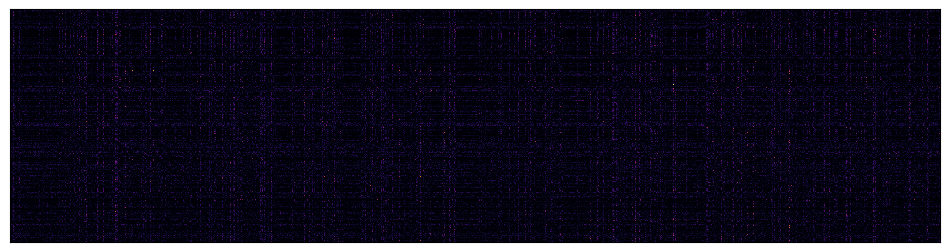

In [3]:
import matplotlib.pyplot as plt
w = vit.vit_b_16.encoder.layers.encoder_layer_0.mlp[0].weight.detach().numpy()
W_ = abs(w)
vmin, vmax = W_.min(), W_.max()
fig, ax = plt.subplots(figsize=(12, 40))
im1 = ax.imshow(W_.T, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
ax.set_xticks([]); ax.set_yticks([]);

In [4]:
eigenvalues_w, eigenvectors_w = np.linalg.eig(w.T @ w)
# Might get some complex dust due to precision.
eigenvalues_w = np.real(eigenvalues_w)
eigenvectors_w = np.real(eigenvectors_w)

In [5]:
vit_init = vit_b_16()
w_init = vit_init.encoder.layers.encoder_layer_0.mlp[0].weight.detach().numpy()
eigenvalues_w_init, eigenvectors_w_init = np.linalg.eig(w_init.T @ w_init)
eigenvalues_w_init = np.real(eigenvalues_w_init)
eigenvectors_w_init = np.real(eigenvectors_w_init)

In [6]:
vit_init.encoder.layers.encoder_layer_0

EncoderBlock(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): MLPBlock(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)

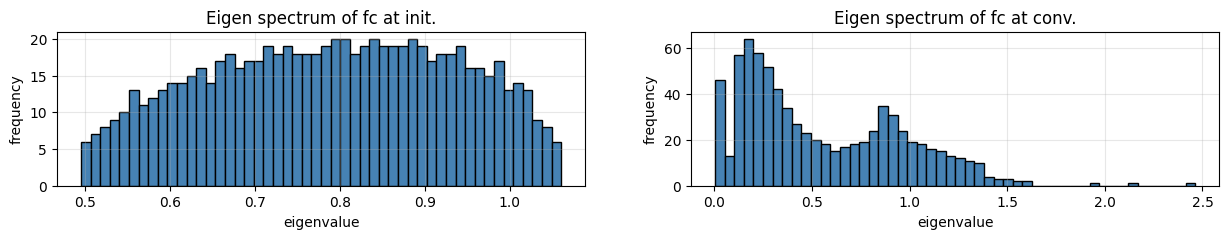

In [7]:
# same with histograms of spectrum.
plt.figure(figsize=(15, 2))

plt.subplot(1, 2, 1)
plt.hist(np.log(np.sqrt(eigenvalues_w_init)+1), bins=50, color='steelblue', edgecolor='black')
plt.title('Eigen spectrum of fc at init.')
plt.xlabel('eigenvalue')
plt.ylabel('frequency')
plt.grid(alpha=0.3)
#plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(np.log(np.sqrt(eigenvalues_w)+1), bins=50, color='steelblue', edgecolor='black')
plt.title('Eigen spectrum of fc at conv.')
plt.xlabel('eigenvalue')
plt.ylabel('frequency')
plt.grid(alpha=0.3)
#plt.yscale('log')

In [22]:
eigenvalues_w, eigenvectors_w = np.linalg.eig(vit_init.heads.head.weight.detach().numpy().T @ vit_init.heads.head.weight.detach().numpy())
# Might get some complex dust due to precision.
eigenvalues_w = np.real(eigenvalues_w)
eigenvectors_w = np.real(eigenvectors_w)

# trying to get the semicircle law.

In [12]:
vit_init = vit_b_16()
w_init = vit_init.encoder.layers.encoder_layer_0.mlp[0].weight.detach().numpy()
u, s, vt = np.linalg.svd(w_init)

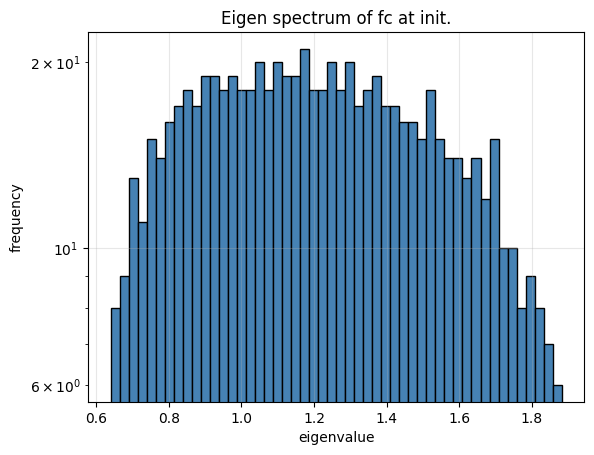

In [13]:
plt.hist(s, bins=50, color='steelblue', edgecolor='black')
plt.title('Eigen spectrum of fc at init.')
plt.xlabel('eigenvalue')
plt.ylabel('frequency')
plt.grid(alpha=0.3)
plt.yscale('log')

# get the fully connected one.

In [23]:
vit

VisionTransformerPredictor(
  (vit_b_16): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
   

In [15]:
fc_init = vit_init.heads.head.weight.detach().numpy()
fc = vit.vit_b_16.heads.head.weight.detach().numpy()

eigenvalues_fc_init, eigenvectors_fc_init = np.linalg.eig(fc_init.T @ fc_init)
# Might get some complex dust due to precision.
eigenvalues_fc_init = np.real(eigenvalues_fc_init)
eigenvectors_fc_init = np.real(eigenvectors_fc_init)

eigenvalues_fc, eigenvectors_fc = np.linalg.eig(fc.T @ fc)
# Might get some complex dust due to precision.
eigenvalues_fc = np.real(eigenvalues_fc)
eigenvectors_fc = np.real(eigenvectors_fc)

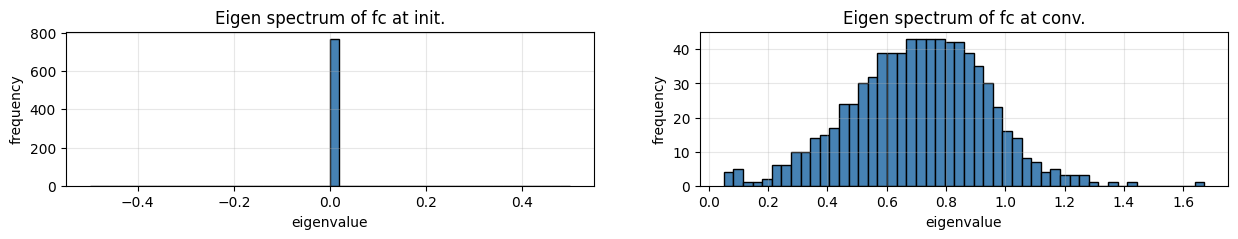

In [16]:
# same with histograms of spectrum.
plt.figure(figsize=(15, 2))

plt.subplot(1, 2, 1)
plt.hist(np.log(np.sqrt(eigenvalues_fc_init)+1), bins=50, color='steelblue', edgecolor='black')
plt.title('Eigen spectrum of fc at init.')
plt.xlabel('eigenvalue')
plt.ylabel('frequency')
plt.grid(alpha=0.3)
#plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(np.log(np.sqrt(eigenvalues_fc)+1), bins=50, color='steelblue', edgecolor='black')
plt.title('Eigen spectrum of fc at conv.')
plt.xlabel('eigenvalue')
plt.ylabel('frequency')
plt.grid(alpha=0.3)
#plt.yscale('log')